In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
df_pretraited = pd.read_csv("dataPreprocessed.csv", low_memory=False)
df_pretraited.head()

,normality,sourceID_freq,accessed_addr_freq,src_dest_same_addr,src_dest_same_type,src_dest_same_loc,value_movement,value_tempin,value_lightOn,value_heatingcontrol,...,value_movement_present,value_lightOn_present,value_heatingcontrol_present,acc_node_event_present,hour_sin,hour_cos,delta_time,events_per_min,is_night,is_work_hours
0,0,0.040505,0.000003,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,0,-0.258819,0.965926,-0.072967,0.209502,0,0
1,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,0.220811,0.274155,0,0
2,0,0.040505,0.018952,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.028332,0.274155,0,0
3,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.054648,0.274155,0,0
4,0,0.040505,0.046168,1,True,1,0.0,-0.753161,0.0,0.0,...,0,0,0,1,-0.258819,0.965926,-0.072456,0.274155,0,0


## Partie1: Exploration des Donnees

#### Split des donnees

In [ ]:
# X = tes features, y = ta target (0=normal, 1=anomalie)
X = df_pretraited.copy()
X = X.drop(columns=['normality'])
y = df_pretraited['normality']


# Split train+val et test (80%-20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Split train et validation (80%-20% du train+val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

print("Train:", len(X_train), "Validation:", len(X_val), "Test:", len(X_test))

Train: 229088 Validation: 57273 Test: 71591


In [ ]:
print("Train (%):\n", y_train.value_counts(normalize=True) * 100)
print("\nValidation (%):\n", y_val.value_counts(normalize=True) * 100)
print("\nTest (%):\n", y_test.value_counts(normalize=True) * 100)

Train (%):
 normality
0    97.201512
1     2.798488
Name: proportion, dtype: float64

Validation (%):
 normality
0    97.201124
1     2.798876
Name: proportion, dtype: float64

Test (%):
 normality
0    97.202162
1     2.797838
Name: proportion, dtype: float64


### Model Random Forest

In [ ]:
# creation du modèle
rf = RandomForestClassifier(
    n_estimators=200,        # nombre d'arbres
    max_depth=10,            # profondeur max pour éviter overfitting
    min_samples_leaf=5,      # nombre minimal d'échantillons par feuille
    class_weight='balanced', # ajuste les poids pour la classe minoritaire
    random_state=42,
    n_jobs=-1
)

# entraînement sur le train
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
joblib.dump(rf, "rf.pkl")

In [ ]:
rf = joblib.load("rf.pkl")
y_val_pred = rf.predict(X_val)
y_val_prob = rf.predict_proba(X_val)[:,1]

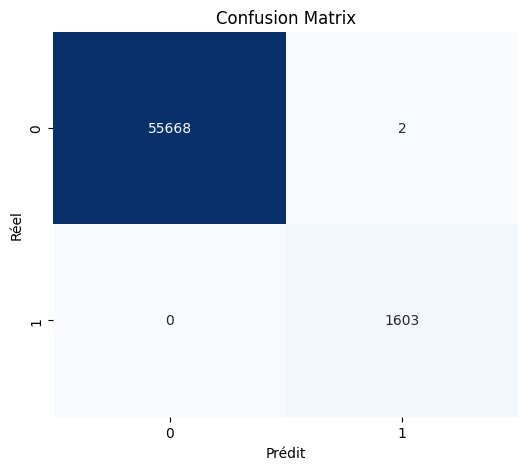

In [ ]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.show()

55668 : vrais négatifs (normaux correctement détectés)

2 : faux positifs (normaux classés comme anomalie)

0 : faux négatifs (anomalies manquées)

1603 : vrais positifs (anomalies correctement détectées)

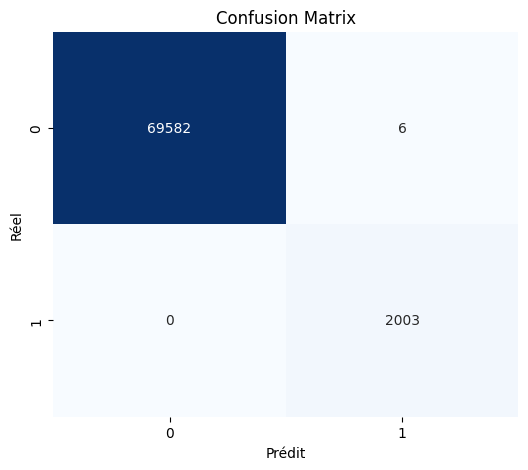

In [ ]:
y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Confusion Matrix')
plt.show()

69582 : vrais négatifs (normaux correctement détectés)

6 : faux positifs (normaux classés comme anomalie)

0 : faux négatifs (anomalies manquées)

2003 : vrais positifs (anomalies correctement détectées)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))
auc = roc_auc_score(y_val, y_val_prob)
print("ROC-AUC:", auc)
precision, recall, thresholds = precision_recall_curve(y_val, y_val_prob)

pr_auc = average_precision_score(y_val, y_val_prob)
print("PR-AUC:", pr_auc)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     55670
           1       1.00      1.00      1.00      1603

    accuracy                           1.00     57273
   macro avg       1.00      1.00      1.00     57273
weighted avg       1.00      1.00      1.00     57273

ROC-AUC: 1.0
PR-AUC: 1.0


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
auc_test = roc_auc_score(y_test, y_test_prob)
print("ROC-AUC:", auc_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)

pr_auc = average_precision_score(y_test, y_test_prob)
print("PR-AUC:", pr_auc)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     69588
           1       1.00      1.00      1.00      2003

    accuracy                           1.00     71591
   macro avg       1.00      1.00      1.00     71591
weighted avg       1.00      1.00      1.00     71591

ROC-AUC: 0.9999999569536884
PR-AUC: 0.9999985052359096


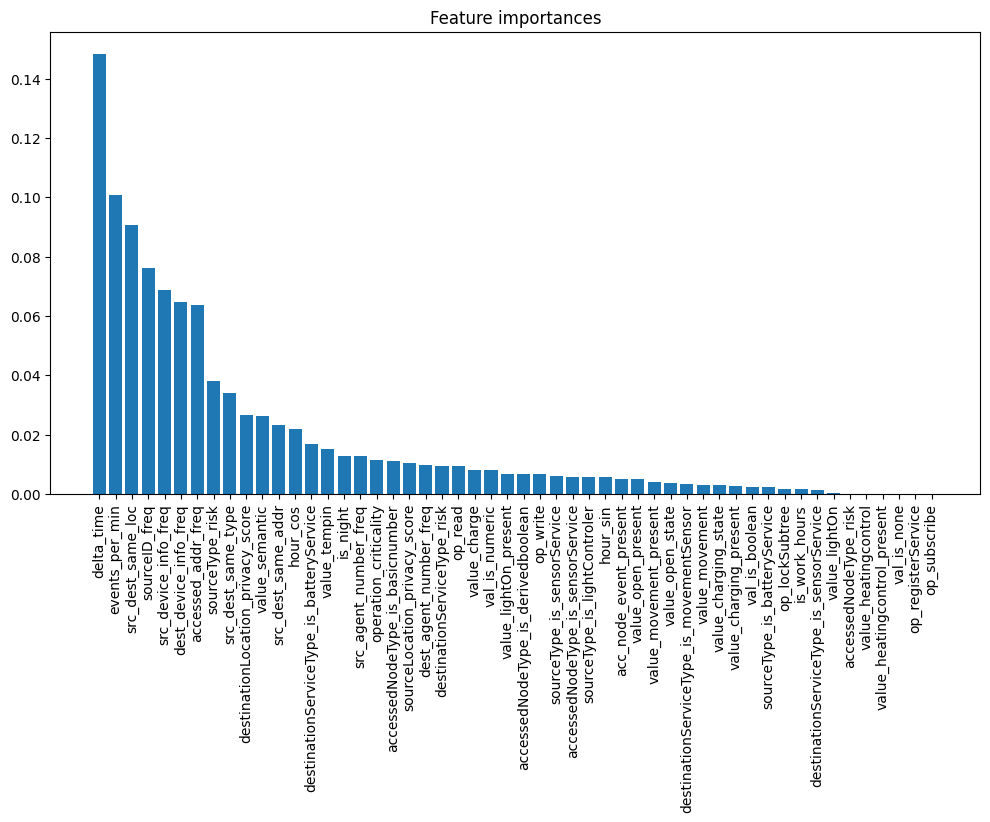

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

0.9999999569536884


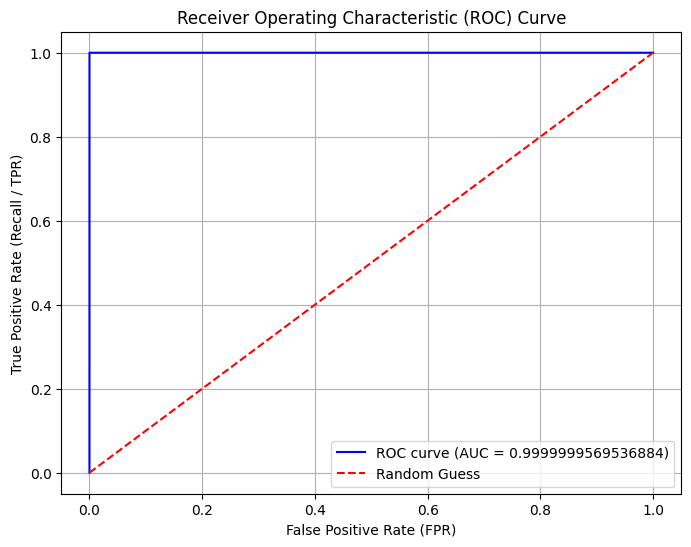

In [ ]:
# Calcul des valeurs pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

print(auc_test)
# Visualisation
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_test})')
plt.plot([0,1], [0,1], color='red', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall / TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()